In [17]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../..')))

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import convert_to_tensor, string
from keras.layers import TextVectorization, Embedding, Layer
import numpy as np
import matplotlib.pyplot as plt

from novel.transformer.components.positional_encoding import PositionEmbeddingLayer, PositionEmbeddingFixedWeights

https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/

In [18]:
def getPositionEncoding(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return P
 
P = getPositionEncoding(seq_len=4, d=4, n=100)
print(P)

[[ 0.          1.          0.          1.        ]
 [ 0.84147098  0.54030231  0.09983342  0.99500417]
 [ 0.90929743 -0.41614684  0.19866933  0.98006658]
 [ 0.14112001 -0.9899925   0.29552021  0.95533649]]


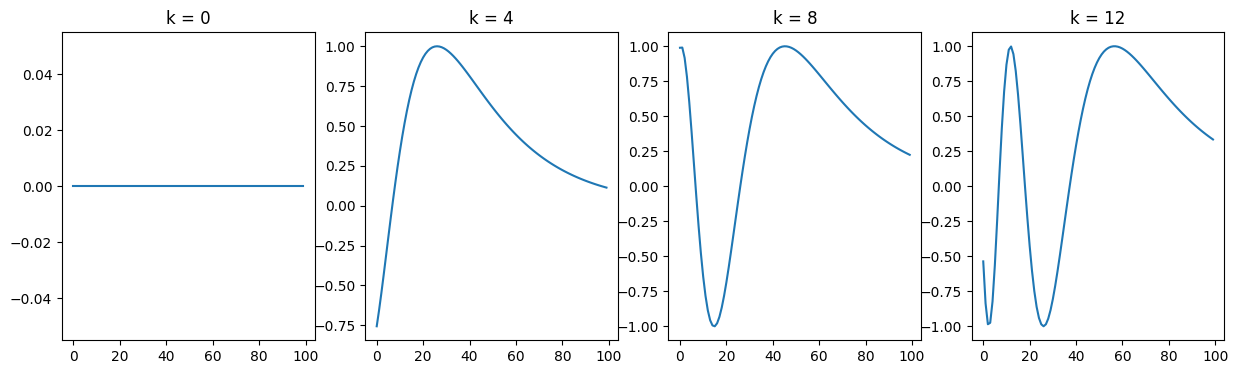

In [19]:
def plotSinusoid(k, d=512, n=10000):
    x = np.arange(0, 100, 1)
    denominator = np.power(n, 2*x/d)
    y = np.sin(k/denominator)
    plt.plot(x, y)
    plt.title('k = ' + str(k))

fig = plt.figure(figsize=(15, 4))    
for i in range(4):
    plt.subplot(141 + i)
    plotSinusoid(i*4)

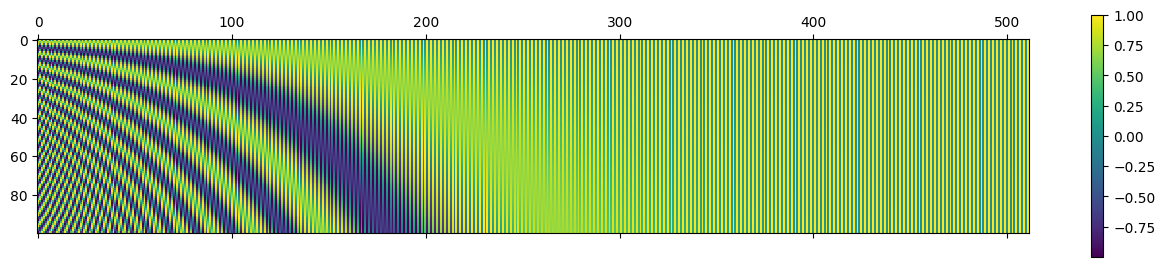

In [20]:
P = getPositionEncoding(seq_len=100, d=512, n=10000)
cax = plt.matshow(P)
plt.gcf().colorbar(cax)

In [21]:
output_sequence_length = 5
vocab_size = 10
sentences = [["I am a robot"], ["you too robot"]]
sentence_data = tf.data.Dataset.from_tensor_slices(sentences)
# Create the TextVectorization layer
vectorize_layer = TextVectorization(
                  output_sequence_length=output_sequence_length,
                  max_tokens=vocab_size)
# Train the layer to create a dictionary
vectorize_layer.adapt(sentence_data)
# Convert all sentences to tensors
word_tensors = convert_to_tensor(sentences, dtype=tf.string)
# Use the word tensors to get vectorized phrases
vectorized_words = vectorize_layer(word_tensors)
print("Vocabulary: ", vectorize_layer.get_vocabulary())
print("Vectorized words: ", vectorized_words)

Vocabulary:  ['', '[UNK]', 'robot', 'you', 'too', 'i', 'am', 'a']
Vectorized words:  tf.Tensor(
[[5 6 7 2 0]
 [3 4 2 0 0]], shape=(2, 5), dtype=int64)


In [22]:
unknown_sentences = [["This is unknown"]]
unknown_word_tensors = convert_to_tensor(unknown_sentences, dtype=tf.string)
print(unknown_word_tensors)
unknown_vectorized_words = vectorize_layer(unknown_word_tensors)
print("Unknown Vectorized words: ", unknown_vectorized_words)
# TextVectorization deals with unkown tokens by giving it the OOV token = 1
# 0 is padding

tf.Tensor([[b'This is unknown']], shape=(1, 1), dtype=string)
Unknown Vectorized words:  tf.Tensor([[1 1 1 0 0]], shape=(1, 5), dtype=int64)


In [23]:
unknown_sentence_data = tf.data.Dataset.from_tensor_slices(unknown_sentences)
# Not possible to dynamically add the unkown data, as this will remove all previously known data
vectorize_layer.adapt(unknown_sentence_data)
unknown_vectorized_words = vectorize_layer(unknown_word_tensors)
print("Vocabulary: ", vectorize_layer.get_vocabulary())
print("Vectorized words: ", unknown_vectorized_words)

Vocabulary:  ['', '[UNK]', 'unknown', 'this', 'is']
Vectorized words:  tf.Tensor([[3 4 2 0 0]], shape=(1, 5), dtype=int64)


In [24]:
# Readd the example sentence data after the OOV example
vectorize_layer.adapt(sentence_data)

In [25]:
output_length = 6
# Again embedding needs a fixed vocab size Attribute Buffer can help solve that to deal with unknowns
word_embedding_layer = Embedding(vocab_size, output_length)
embedded_words = word_embedding_layer(vectorized_words)
print(embedded_words)

tf.Tensor(
[[[-0.03542231  0.01393906 -0.02141094 -0.04041272  0.00654142
   -0.01444455]
  [ 0.04998614 -0.03313539 -0.01894698  0.02169944 -0.00969632
    0.00901803]
  [ 0.03991309  0.01430304  0.03398864 -0.04159329  0.03872266
   -0.00824064]
  [-0.01935766  0.02816364  0.00808581 -0.04652336 -0.00086546
    0.00289436]
  [-0.04053457  0.02520824 -0.0435991  -0.00898515  0.02855864
    0.00211372]]

 [[ 0.02455762  0.0086602  -0.0459901  -0.00556945 -0.02684996
    0.02611769]
  [ 0.02753984 -0.02210442 -0.0422451   0.00285444 -0.01836029
    0.02955444]
  [-0.01935766  0.02816364  0.00808581 -0.04652336 -0.00086546
    0.00289436]
  [-0.04053457  0.02520824 -0.0435991  -0.00898515  0.02855864
    0.00211372]
  [-0.04053457  0.02520824 -0.0435991  -0.00898515  0.02855864
    0.00211372]]], shape=(2, 5, 6), dtype=float32)


In [26]:
position_embedding_layer = Embedding(output_sequence_length, output_length)
position_indices = tf.range(output_sequence_length)
embedded_indices = position_embedding_layer(position_indices)
print(embedded_indices)

tf.Tensor(
[[ 0.02164978  0.02914102  0.0081826  -0.00157337 -0.02569249 -0.01085221]
 [ 0.03799683 -0.03628469  0.00907606 -0.01995575  0.01879784 -0.03003331]
 [ 0.04876241  0.0152504  -0.02596851  0.01733211 -0.02086009  0.0031758 ]
 [ 0.04241225 -0.01658425 -0.01388041  0.04970899 -0.04627184  0.03568598]
 [ 0.03442417 -0.00273909 -0.0325179   0.00253141  0.00277661 -0.01917365]], shape=(5, 6), dtype=float32)


In [27]:
final_output_embedding = embedded_words + embedded_indices
print("Final output: ", final_output_embedding)

Final output:  tf.Tensor(
[[[-0.01377253  0.04308008 -0.01322835 -0.0419861  -0.01915107
   -0.02529676]
  [ 0.08798297 -0.06942008 -0.00987092  0.00174369  0.00910152
   -0.02101529]
  [ 0.0886755   0.02955344  0.00802014 -0.02426118  0.01786257
   -0.00506485]
  [ 0.0230546   0.01157938 -0.0057946   0.00318563 -0.0471373
    0.03858035]
  [-0.00611039  0.02246914 -0.07611699 -0.00645374  0.03133525
   -0.01705992]]

 [[ 0.0462074   0.03780122 -0.0378075  -0.00714282 -0.05254245
    0.01526548]
  [ 0.06553667 -0.0583891  -0.03316904 -0.01710131  0.00043755
   -0.00047888]
  [ 0.02940475  0.04341403 -0.0178827  -0.02919125 -0.02172555
    0.00607016]
  [ 0.00187769  0.00862398 -0.0574795   0.04072384 -0.0177132
    0.0377997 ]
  [-0.00611039  0.02246914 -0.07611699 -0.00645374  0.03133525
   -0.01705992]]], shape=(2, 5, 6), dtype=float32)


In [28]:
my_embedding_layer = PositionEmbeddingLayer(output_sequence_length,
                                            vocab_size, output_length)
embedded_layer_output = my_embedding_layer(vectorized_words)
print("Output from my_embedded_layer: ", embedded_layer_output)

Output from my_embedded_layer:  tf.Tensor(
[[[ 0.04379772  0.03765023  0.04266956 -0.04588705  0.0634796
    0.07042402]
  [-0.03476731  0.03378579 -0.06684837  0.01191802 -0.01435999
    0.01404082]
  [-0.02244157 -0.02437217 -0.04263252 -0.02297771 -0.0063333
   -0.00877882]
  [ 0.01872043  0.03781532  0.04590787  0.03377588 -0.00191377
    0.04915   ]
  [-0.05381377  0.02150147  0.0077521   0.00247501  0.00115869
   -0.07589804]]

 [[ 0.03574218  0.0275126   0.01160878  0.03650296  0.03424032
    0.05836859]
  [-0.04673637 -0.01965846 -0.02853661  0.025542    0.01874222
    0.03329359]
  [ 0.01304635 -0.0207804  -0.00074099  0.0296984   0.02250664
    0.00722379]
  [-0.07364501  0.05947908  0.05707856 -0.00481356 -0.08437793
   -0.02685268]
  [-0.05381377  0.02150147  0.0077521   0.00247501  0.00115869
   -0.07589804]]], shape=(2, 5, 6), dtype=float32)


In [29]:
attnisallyouneed_embedding = PositionEmbeddingFixedWeights(output_sequence_length,
                                            vocab_size, output_length)
attnisallyouneed_output = attnisallyouneed_embedding(vectorized_words)
print("Output from my_embedded_layer: ", attnisallyouneed_output)

Output from my_embedded_layer:  tf.Tensor(
[[[-0.9589243   1.2836622   0.23000172  1.9731903   0.01077196
    1.9999421 ]
  [ 0.56205547  1.5004725   0.3213085   1.9603932   0.01508068
    1.9999142 ]
  [ 1.566284    0.3377554   0.41192317  1.9433732   0.01938933
    1.999877  ]
  [ 1.0504174  -1.4061394   0.2314966   1.9860148   0.01077211
    1.9999698 ]
  [-0.7568025   0.3463564   0.18459873  1.982814    0.00861763
    1.9999628 ]]

 [[ 0.14112     0.0100075   0.1387981   1.9903207   0.00646326
    1.9999791 ]
  [ 0.08466846 -0.11334133  0.23099795  1.9817369   0.01077207
    1.9999605 ]
  [ 1.8185948  -0.8322937   0.185397    1.9913884   0.00861771
    1.9999814 ]
  [ 0.14112     0.0100075   0.1387981   1.9903207   0.00646326
    1.9999791 ]
  [-0.7568025   0.3463564   0.18459873  1.982814    0.00861763
    1.9999628 ]]], shape=(2, 5, 6), dtype=float32)


In [30]:
technical_phrase = "to understand machine learning algorithms you need" +\
                   " to understand concepts such as gradient of a function "+\
                   "Hessians of a matrix and optimization etc"
wise_phrase = "patrick henry said give me liberty or give me death "+\
              "when he addressed the second virginia convention in march"

total_vocabulary = 200
sequence_length = 20
final_output_len = 50
phrase_vectorization_layer = TextVectorization(
                  output_sequence_length=sequence_length,
                  max_tokens=total_vocabulary)
# Learn the dictionary
phrase_vectorization_layer.adapt([technical_phrase, wise_phrase])
# Convert all sentences to tensors
phrase_tensors = convert_to_tensor([technical_phrase, wise_phrase], 
                                   dtype=tf.string)
# Use the word tensors to get vectorized phrases
vectorized_phrases = phrase_vectorization_layer(phrase_tensors)

random_weights_embedding_layer = PositionEmbeddingLayer(sequence_length, 
                                                        total_vocabulary,
                                                        final_output_len)
fixed_weights_embedding_layer = PositionEmbeddingFixedWeights(sequence_length, 
                                                        total_vocabulary,
                                                        final_output_len)
random_embedding = random_weights_embedding_layer(vectorized_phrases)
fixed_embedding = fixed_weights_embedding_layer(vectorized_phrases)

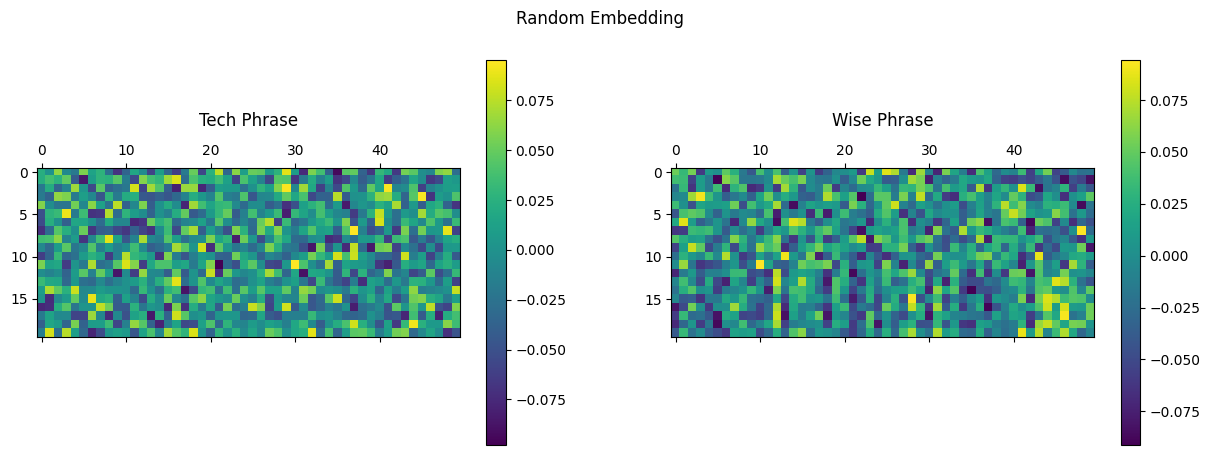

In [31]:
fig = plt.figure(figsize=(15, 5))    
title = ["Tech Phrase", "Wise Phrase"]
for i in range(2):
    ax = plt.subplot(1, 2, 1+i)
    matrix = tf.reshape(random_embedding[i, :, :], (sequence_length, final_output_len))
    cax = ax.matshow(matrix)
    plt.gcf().colorbar(cax)   
    plt.title(title[i], y=1.2)
fig.suptitle("Random Embedding")
plt.show()

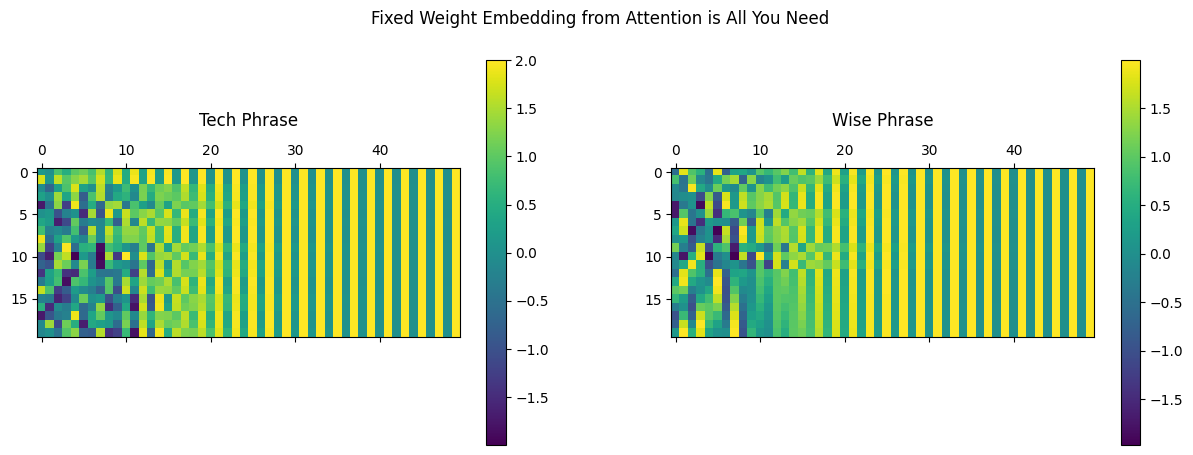

In [32]:
fig = plt.figure(figsize=(15, 5))    
title = ["Tech Phrase", "Wise Phrase"]
for i in range(2):
    ax = plt.subplot(1, 2, 1+i)
    matrix = tf.reshape(fixed_embedding[i, :, :], (sequence_length, final_output_len))
    cax = ax.matshow(matrix)
    plt.gcf().colorbar(cax)   
    plt.title(title[i], y=1.2)
fig.suptitle("Fixed Weight Embedding from Attention is All You Need")
plt.show()